In [123]:
%%javascript
/**********************************************************************************************
Known Mathjax Issue with Chrome - a rounding issue adds a border to the right of mathjax markup
https://github.com/mathjax/MathJax/issues/1300
A quick hack to fix this based on stackoverflow discussions: 
http://stackoverflow.com/questions/34277967/chrome-rendering-mathjax-equations-with-a-trailing-vertical-line
**********************************************************************************************/

$('.math>span').css("border-left-color","transparent")

<IPython.core.display.Javascript object>

In [124]:
%reload_ext autoreload
%autoreload 2

# MIDS - w261 Machine Learning At Scale
__Course Lead:__ Dr James G. Shanahan (__email__ Jimi via  James.Shanahan _AT_ gmail.com)

## Assignment - HW10


---
__Name:__  Jackson Lane
__Class:__ MIDS w261 (Section Summer 2016 Group 33)     
__Email:__  jelane@iSchool.Berkeley.edu     
__Week:__   10

# Table of Contents <a name="TOC"></a> 

1.  [HW Introduction](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
    10.0.  [Short Answer Questions](#HW10.0)    
    10.1.  [Word Count plus sorting](#HW10.1)   
    10.2.  [MLlib-centric Kmeans](#HW10.2)    
    10.3.  [Homegrown KMeans in Spark](#HW10.3)    
    10.4.  [Making Homegrown KMeans more efficient](#HW10.4)  
    10.5.  [OPTIONAL Weighted KMeans](#HW10.5)  
    10.6.  [OPTIONAL Linear Regression](#HW10.6)  
    10.7.  [OPTIONAL Error surfaces](#HW10.7)



<a name="1">
# 1 Instructions
[Back to Table of Contents](#TOC)
* Homework submissions are due by Tueday, 07/28/2016 at 11AM (West Coast Time).


* Prepare a single Jupyter note, please include questions, and question numbers in the questions and in the responses.
Submit your homework notebook via the following form:

   + [Submission Link - Google Form](
https://docs.google.com/forms/d/1ZOr9RnIe_A06AcZDB6K1mJN4vrLeSmS2PD6Xm3eOiis/viewform?usp=send_form 
)


### Documents:
* IPython Notebook, published and viewable online.
* PDF export of IPython Notebook.
    
<a name="2">
# 2 Useful References
[Back to Table of Contents](#TOC)

* Karau, Holden, Konwinski, Andy, Wendell, Patrick, & Zaharia, Matei. (2015). Learning Spark: Lightning-fast big data analysis. Sebastopol, CA: O’Reilly Publishers.
* Hastie, Trevor, Tibshirani, Robert, & Friedman, Jerome. (2009). The elements of statistical learning: Data mining, inference, and prediction (2nd ed.). Stanford, CA: Springer Science+Business Media. (Download for free [here](http://statweb.stanford.edu/~tibs/ElemStatLearn/printings/ESLII_print10.pdf))

<a name="3">
# 3 HW Problems
[Back to Table of Contents](#TOC)

### Set up Spark Env

In [125]:
import os
import sys 
from pyspark import SparkContext, SparkConf,SparkFiles

spark_home = os.environ['SPARK_HOME']
if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.9-src.zip'))
try:
    sc.stop()
except:
    pass
conf = SparkConf().setAppName("my app").setMaster("spark://master:7077")
sc = SparkContext(conf=conf)

<a name="HW10.0"></a><h2 style="color:darkblue"> HW10.0: Short answer questions </h2>
[Back to Table of Contents](#TOC)


__What is Apache Spark and how is it different to Apache Hadoop? __

Apache Spark™ is a fast and general engine for large-scale data processing.

It's different from Hadoop in two ways.  First, Hadoop is a whole ecosystem of software, including HDFS, MapReduce, Hive, and Pig.  Spark on the other hand is just a processing engine like MapReduce.  For other functionalities, like file management, Spark needs to rely on other programs or protocols, such as HDFS or NAS.  

Second, Spark does not attempt to distirbute incoming data across nodes like Hadoop does.  Instead, Spark performs most computations within memory and disk on eahc worker and assumes that all the erelvant data will arleayd be accessible to that worker.  So this means that if you want to process a text file on Spark Cluster, you'll need to put that textfile either on a shared network drive or on HDFS prior to running the job.  Hadoop MapReduce on the other hand dsitributes incoming data to all of its worker nodes prior to computation.  Overall, this means that Spark is faster than Hadoop MapReduce, since Spark does not spend time on resource distribution, but Hadoop MapReduce is more flexible. 

__Fill in the blanks:
Spark API consists of interfaces to develop applications based on it in Java, ___ Python, Scala __ languages (list languages). __

<hr>

__Using Spark, resource management can be done either in a single server instance or using a framework such as Mesos, Hadoop, or Yarn in a distributed manner. __

<hr>

__What is an RDD and show a fun example of creating one and bringing the first element back to the driver program. __

<hr>
A Resilient Distributed Dataset is what Spark performs most of its operations on.  It's a data source that is either distributed amongst or accessible from the worker nodes.

In [140]:
RDD = sc.parallelize([3,2,6,6,3,1,7,4,2,1,5])
RDD.distinct().collect()

[1, 2, 3, 4, 5, 6, 7]

<a name="HW10.1"> <h2 style="color:darkgreen">HW10.1 WordCount plus sorting </h2>
[Back to Table of Contents](#TOC)

The following notebooks will be useful to jumpstart this collection of Homework exercises:


* [Example Notebook with Debugging tactics in Spark](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/jqjllp8kmf1eolk/WordCountDebugging-Example.ipynb)
* [Word Count Quiz](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/vgmpivsi4rvqz0s/WordCountQuiz.ipynb)
* [Work Count Solution](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/dxv3dmp1vluuo8i/WordCountQuiz-Solution.ipynb)

---
In Spark write the code to count how often each word appears in a text document (or set of documents). Please use this homework document (with no solutions in it) as a the example document to run an experiment.  Report the following: 
* provide a sorted list of tokens in decreasing order of frequency of occurence limited to [top 20 most frequent only] and [bottom 10 least frequent]. 


__OPTIONAL__ 
Feel free to do a secondary sort where words with the same frequncy are sorted alphanumerically increasing. Plseas refer to the [following notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/uu5afr3ufpm9fy8/SecondarySort.ipynb)
 for examples of secondary sorts in Spark. Please provide the following [top 20 most frequent terms only] and [bottom 10 least frequent terms]

__NOTE__ [Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__

In [126]:
import re, sys
def lineWordCount(line):
    wordCounts = {}
    for w in re.findall(r"[\w]+",line):
        wordCounts[w]=wordCounts.get(w,0) + 1   
    return (wordCounts.items())  



In [127]:
def wordCount(url):
    !wget $url -O tmp
    lines = sc.textFile('tmp').cache()
    result= lines.flatMap(lineWordCount).reduceByKey(lambda a,b: a+b).takeOrdered(20, key=lambda x: x[1]*-1)
    !rm -f tmp
    return result


In [128]:
wordCount("https://dl.dropbox.com/s/zhsr8w7wmb8mcnc/MIDS-w261-HW10-Template-2016-07-22.ipynb")


--2016-07-30 17:19:44--  https://dl.dropbox.com/s/zhsr8w7wmb8mcnc/MIDS-w261-HW10-Template-2016-07-22.ipynb
Resolving dl.dropbox.com (dl.dropbox.com)... 45.58.69.5
Connecting to dl.dropbox.com (dl.dropbox.com)|45.58.69.5|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://dl.dropboxusercontent.com/s/zhsr8w7wmb8mcnc/MIDS-w261-HW10-Template-2016-07-22.ipynb [following]
--2016-07-30 17:19:45--  https://dl.dropboxusercontent.com/s/zhsr8w7wmb8mcnc/MIDS-w261-HW10-Template-2016-07-22.ipynb
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 45.58.69.5
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|45.58.69.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21760 (21K) [text/plain]
Saving to: ‘tmp’

100%[======================================>] 21,760      --.-K/s   in 0s      

2016-07-30 17:19:45 (150 MB/s) - ‘tmp’ saved [21760/21760]



[(u'n', 216),
 (u'the', 72),
 (u'of', 50),
 (u'metadata', 49),
 (u'cell_type', 47),
 (u'source', 47),
 (u'a', 46),
 (u'code', 42),
 (u'HW10', 40),
 (u'and', 39),
 (u'to', 35),
 (u'in', 32),
 (u'collapsed', 30),
 (u'outputs', 30),
 (u'execution_count', 30),
 (u'true', 29),
 (u'h2', 26),
 (u'1', 22),
 (u'com', 19),
 (u'name', 19)]

<a name="HW10.1.1"><h2 style="color:darkgreen">HW10.1.1 </h2>
[Back to Table of Contents](#TOC)

Modify the above word count code to count words that begin with lower case letters (a-z) and report your findings. Again sort the output words in decreasing order of frequency.


In [84]:
#The only change we need to make is in the re.findall line.  
#Instead of looking for just words, we need to find words that begin with a lower case letter
#Since there is no quick shorthand for this in regex, we need to manually specify it

import re
def lineWordCount(line):
    wordCounts = {}
    for w in re.findall(r"\b[a-z][a-zA-Z0-9]*\b",line):
        if wordCounts.has_key(w):
            wordCounts[w]=wordCounts[w]+1
        else:
            wordCounts[w]=1
    for key, value in  wordCounts.items():
        print key,":", value      
    return (wordCounts.items())  



In [85]:
## Drivers & Runners
def wordCount(url):
    !wget $url -O tmp
    lines = sc.textFile('tmp').cache()
    result= lines.flatMap(lineWordCount).reduceByKey(lambda a,b: a+b).takeOrdered(20, key=lambda x: x[1]*-1)
    !rm -f tmp
    return result


In [86]:
wordCount("https://dl.dropbox.com/s/zhsr8w7wmb8mcnc/MIDS-w261-HW10-Template-2016-07-22.ipynb")


--2016-07-28 00:34:14--  https://dl.dropbox.com/s/zhsr8w7wmb8mcnc/MIDS-w261-HW10-Template-2016-07-22.ipynb
Resolving dl.dropbox.com (dl.dropbox.com)... 108.160.172.5
Connecting to dl.dropbox.com (dl.dropbox.com)|108.160.172.5|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://dl.dropboxusercontent.com/s/zhsr8w7wmb8mcnc/MIDS-w261-HW10-Template-2016-07-22.ipynb [following]
--2016-07-28 00:34:14--  https://dl.dropboxusercontent.com/s/zhsr8w7wmb8mcnc/MIDS-w261-HW10-Template-2016-07-22.ipynb
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 45.58.69.101
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|45.58.69.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21760 (21K) [text/plain]
Saving to: ‘tmp’

100%[======================================>] 21,760      --.-K/s   in 0s      

2016-07-28 00:34:15 (214 MB/s) - ‘tmp’ saved [21760/21760]



[(u'n', 216),
 (u'the', 72),
 (u'of', 50),
 (u'metadata', 49),
 (u'source', 47),
 (u'a', 46),
 (u'code', 42),
 (u'and', 39),
 (u'to', 35),
 (u'in', 32),
 (u'collapsed', 30),
 (u'outputs', 30),
 (u'true', 29),
 (u'h2', 26),
 (u'com', 19),
 (u'name', 19),
 (u'with', 18),
 (u'this', 18),
 (u'markdown', 17),
 (u'color', 15)]

<a name="HW10.2"> <h2 style="color:darkblue"> HW10.2: MLlib-centric KMeans</h2>
[Back to Table of Contents](#TOC)

Using the following  MLlib-centric KMeans code snippet: 

<pre>
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt


# Load and parse the data
# NOTE  kmeans_data.txt is available here 
#          https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 
data = sc.textFile("kmeans_data.txt")  
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10,
        runs=10, initializationMode="random")

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

# Save and load model
clusters.save(sc, "myModelPath")
sameModel = KMeansModel.load(sc, "myModelPath")

</pre>

__NOTE__ <p> The  __kmeans_data.txt__ is available here https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 

__TASKS__
* Run this code snippet and list the clusters that your find.
* compute the Within Set Sum of Squared Errors for the found clusters. Comment on your findings.

In [132]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt


# Load and parse the data
# NOTE  kmeans_data.txt is available here 
#          https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 
data = sc.textFile("kmeans_data.txt").cache()
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10,
        runs=10, initializationMode="random")

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

# Save and load model
sameModel = clusters
#clusters.save(sc, "myModelPath")
#sameModel = KMeansModel.load(sc, "myModelPath")


Within Set Sum of Squared Error = 0.692820323028


In [133]:
print "Clusters: ", map(str,sameModel.clusterCenters)
print "WSSSE: ", WSSSE

Clusters:  ['[ 9.1  9.1  9.1]', '[ 0.1  0.1  0.1]']
WSSSE:  0.692820323028


Comment Here

<a name="HW10.3"><h2 style="color:darkgreen"> HW10.3: Homegrown KMeans in Spark </h2>
[Back to Table of Contents](#TOC)

Download the following KMeans [notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb).

Generate 3 clusters with 100 (one hundred) data points per cluster (using the code provided). Plot the data.
Then run MLlib's Kmean implementation on this data  and report your results as follows:

* plot the resulting clusters after 1 iteration, 10 iterations, after 20 iterations, after 100 iterations.
* in each plot please report the Within Set Sum of Squared Errors for the found clusters (as part of the title WSSSE). Comment on the progress of this measure as  the KMEans algorithms runs for more iterations. Then plot the WSSSE as a function of the iteration (1, 10, 20, 30, 40, 50, 100).



Data Generation

In [110]:
%matplotlib inline
import numpy as np
import pylab 
import json
size1 = size2 = size3 = 100
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('data.csv',data,delimiter = ',')

# Data Visualiazation

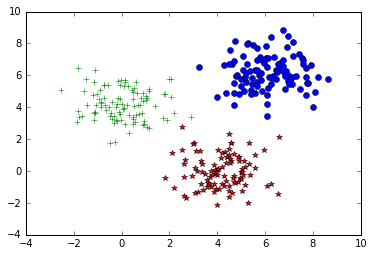

In [111]:
pylab.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red')
pylab.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue')
pylab.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green')
pylab.show()

In [112]:
import numpy as np

#Calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))

#plot centroids and data points for each iteration
def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()

Iteration1
WSSSE = 692.042
[[ 0.  0.]
 [ 2.  2.]
 [ 0.  7.]]


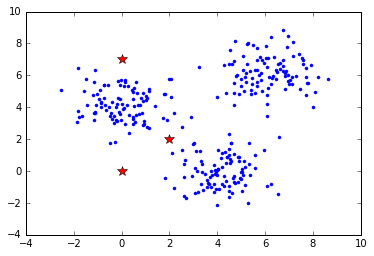

Iteration10
WSSSE = 387.242
[[ 0.10380909  3.77016852]
 [ 3.86435207  0.14896994]
 [ 6.09151556  6.03661616]]


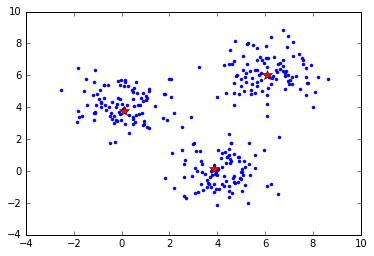

Iteration20
WSSSE = 387.242
[[ 0.10380909  3.77016852]
 [ 3.86435207  0.14896994]
 [ 6.09151556  6.03661616]]


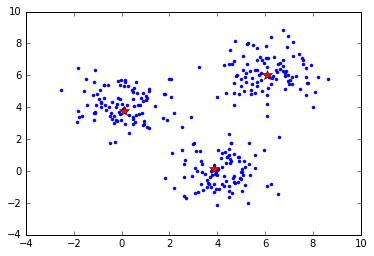

Iteration100
WSSSE = 387.242
[[ 0.10380909  3.77016852]
 [ 3.86435207  0.14896994]
 [ 6.09151556  6.03661616]]


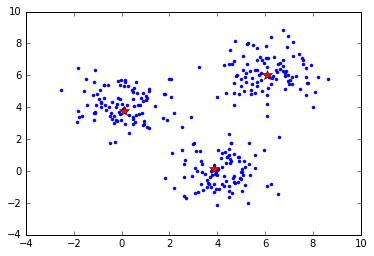

Final Results:
[[ 0.10380909  3.77016852]
 [ 3.86435207  0.14896994]
 [ 6.09151556  6.03661616]]


In [113]:
errorPlot = []
K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

data = sc.textFile("data.csv").cache()
iter_num = 0
for i in range(100): 
    iter_num = iter_num + 1 
    parsedData = data.map(lambda line: array([float(x) for x in line.split(',')]))

    # Build the model (cluster the data)
    clusters = KMeans.train(parsedData, 3, maxIterations=iter_num,
            runs=10, initializationMode="random")

    # Evaluate clustering by computing Within Set Sum of Squared Errors
    def error(point):
        center = clusters.centers[clusters.predict(point)]
        return sqrt(sum([x**2 for x in (point - center)]))

    WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    errorPlot.append(WSSSE)

    if (iter_num == 1 or iter_num==10 or iter_num==20 or iter_num ==100):
        print "Iteration" + str(iter_num)
        print "WSSSE = %.3f" % WSSSE

        print centroids
        plot_iteration(centroids)
    centroids = centroids_new
print "Final Results:"
print centroids

## Plot WSSSE

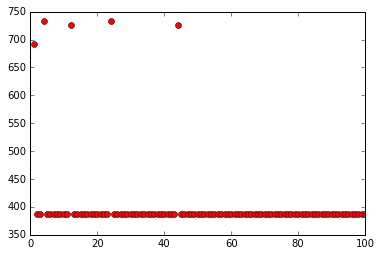

In [115]:
pylab.plot(list(range(1,101)), errorPlot,'o', color = 'red')


This chart shows that the WSSSE is mostly flat, but occasionally veers off seemingly at random.  In theory, the WSSSE should decrease or remain approximately constant with each iteration.  Seeing the WSSSE go from 400 to 750 and back then to 400 suggests that there's some sort of problem here.  

I don't know how the MLLib package in Spark works, but my guess would be that there is some sort of synchronization issue between the different machines in the cluster.

<a name="HW10.4"><h2 style="color:darkblue"> HW10.4: KMeans Experiments  </h2>
[Back to Table of Contents](#TOC)

Using this provided [homegrown Kmeans code](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb)   repeat the experiments in HW10.3. Explain any differences between the results in HW10.3 and HW10.4. 

## Distributed KMeans in Spark

Iteration1
WSSSE = 1116.063
[[ 0.  0.]
 [ 2.  2.]
 [ 0.  7.]]


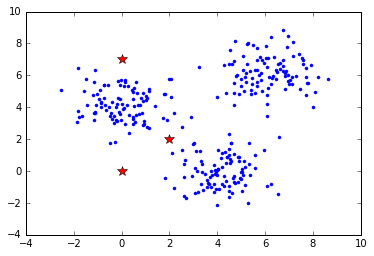

Iteration10
WSSSE = 387.242
[[ 4.17952284 -0.02090319]
 [ 6.11794239  6.18078708]
 [ 0.06590989  4.17708761]]


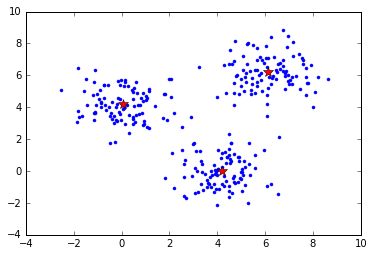

Iteration20
WSSSE = 387.242
[[ 4.17952284 -0.02090319]
 [ 6.11794239  6.18078708]
 [ 0.06590989  4.17708761]]


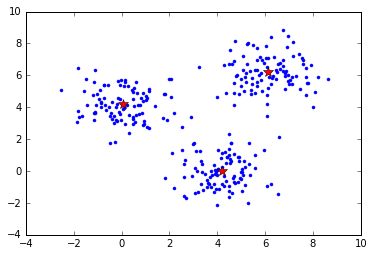

Iteration100
WSSSE = 387.242
[[ 4.17952284 -0.02090319]
 [ 6.11794239  6.18078708]
 [ 0.06590989  4.17708761]]


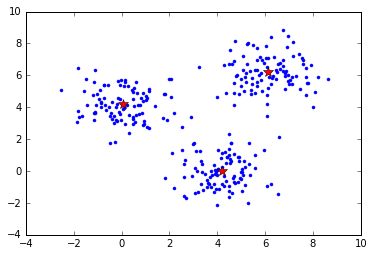

Final Results:
[[ 4.17952284 -0.02090319]
 [ 6.11794239  6.18078708]
 [ 0.06590989  4.17708761]]


In [116]:
errorPlot = []
K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

D = sc.textFile("data.csv").cache()
iter_num = 0
for i in range(100):  
    res = D.map(nearest_centroid).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    #res [(0, (array([  2.66546663e+00,   3.94844436e+03]), 1001)  ), 
    #     (2, (array([ 6023.84995923,  5975.48511018]), 1000)), 
    #     (1, (array([ 3986.85984761,    15.93153464]), 999))]
    # res[1][1][1] returns 1000 here
    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
    #if np.sum(np.absolute(centroids_new-centroids))<0.01:
        #break
    def error(line):
        center = centroids[nearest_centroid(line)[0]]
        x,y = line.split(',')
        x = float(x)
        y = float(y)
        return sqrt((x-center[0])**2 + (y-center[1])**2)
    WSSSE = D.map(error).reduce(lambda x, y: x + y)
    errorPlot.append(WSSSE)
    iter_num = iter_num + 1 

    if (iter_num == 1 or iter_num==10 or iter_num==20 or iter_num ==100):
        print "Iteration" + str(iter_num)
        print "WSSSE = %.3f" % WSSSE

        print centroids
        plot_iteration(centroids)
    centroids = centroids_new
print "Final Results:"
print centroids

## Plot of WSSSE

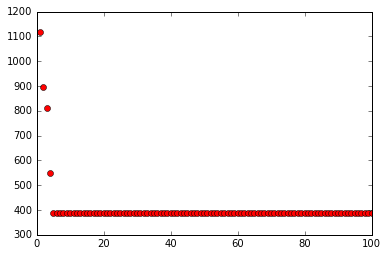

In [117]:
pylab.plot(list(range(1,101)), errorPlot,'o', color = 'red')


The homegrown KMeans code has a stable WSSSE that is decreasing during the first few iterations and then remains flat once the algorithm reaches convergence.  I don't know how the MLLib one works, but this reinforces my guess that the MLLib KMeans algoritm had synchronization issues.

In the homegrown algorithm, we only used Spark to compute one iteration at a time.  After each iteration, we got the processed the new centroids on the client machine.  This type of barrier synchronization prevents different nodes in the Spark cluster from processing different centroid data.  

But in the MLLib code, we had Spark perform all iterations in a single Spark job.  

However, I'm going to bet that the MLLib algorithm is faster than our homegrown algorithm, since it doesn't need to keep on sending the centroids back and forth between the cluster machines, master, and client.  Likely, the  

<a name="HW10.4.1"><h2 style="color:darkblue"> HW10.4.1: Making Homegrown KMeans more efficient  </h2>
[Back to Table of Contents](#TOC)

The above provided homegrown KMeans implentation in not the most efficient. How can you make it more efficient? Make this change in the code and show it work and comment on the gains you achieve. 

### HINT: have a look at  [this linear regression notebook](    http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/atzqkc0p1eajuz6/LinearRegression-Notebook-Challenge.ipynb)

In [118]:
#As mentioned in the previous problem, the MLLib algorithm is probably faster 
# than the homegrown algorithm because the homegrown algorithm needs to send the
# centroids back and forth between the worker nodes, master, and client.  
#We can reduce back and forth between the worker and master nodes by by using
# broadcasts instead of closures to pass centroid information


import numpy as np
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt

#Rewritten to not use centroids in closure
def nearest_centroid(line,centroids):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))

Iteration1
WSSSE = 1116.063
[[ 0.  0.]
 [ 2.  2.]
 [ 0.  7.]]


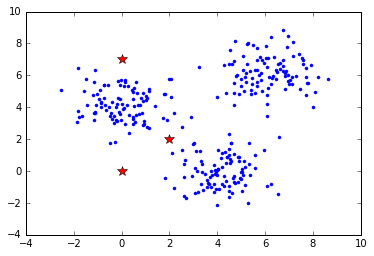

Iteration10
WSSSE = 387.242
[[ 4.17952284 -0.02090319]
 [ 6.11794239  6.18078708]
 [ 0.06590989  4.17708761]]


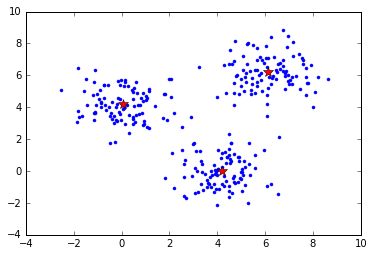

Iteration20
WSSSE = 387.242
[[ 4.17952284 -0.02090319]
 [ 6.11794239  6.18078708]
 [ 0.06590989  4.17708761]]


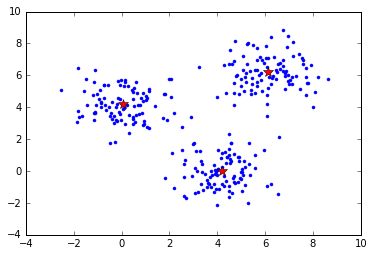

Iteration100
WSSSE = 387.242
[[ 4.17952284 -0.02090319]
 [ 6.11794239  6.18078708]
 [ 0.06590989  4.17708761]]


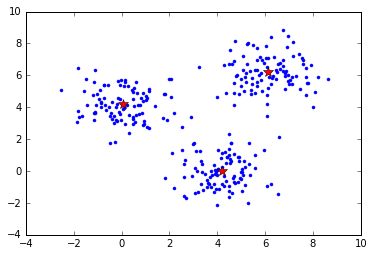

Final Results:
[[ 4.17952284 -0.02090319]
 [ 6.11794239  6.18078708]
 [ 0.06590989  4.17708761]]


In [121]:
errorPlot = []
K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

D = sc.textFile("data.csv").cache()
iter_num = 0
for i in range(100):  
    #Store centroids in a broacast variable
    wBroadCast = sc.broadcast(centroids)
    #Retrieve centroids from broadcast variable
    res = D.map(lambda m: nearest_centroid(m,wBroadCast.value)).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    #res [(0, (array([  2.66546663e+00,   3.94844436e+03]), 1001)  ), 
    #     (2, (array([ 6023.84995923,  5975.48511018]), 1000)), 
    #     (1, (array([ 3986.85984761,    15.93153464]), 999))]
    # res[1][1][1] returns 1000 here
    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  

    #divide by cluster size
    #if np.sum(np.absolute(centroids_new-centroids))<0.01:
        #break
    def error(line):
        center = centroids[nearest_centroid(line,centroids)[0]]
        x,y = line.split(',')
        x = float(x)
        y = float(y)
        return sqrt((x-center[0])**2 + (y-center[1])**2)
    WSSSE = D.map(error).reduce(lambda x, y: x + y)
    errorPlot.append(WSSSE)
    iter_num = iter_num + 1 

    if (iter_num == 1 or iter_num==10 or iter_num==20 or iter_num ==100):
        print "Iteration" + str(iter_num)
        print "WSSSE = %.3f" % WSSSE

        print centroids
        plot_iteration(centroids)
    centroids = centroids_new
print "Final Results:"
print centroids

## Plot of WSSSE

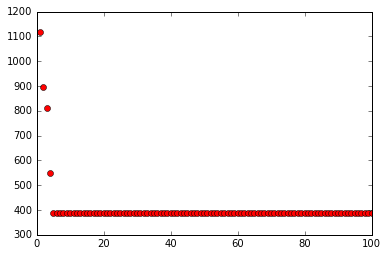

In [122]:
pylab.plot(list(range(1,101)), errorPlot,'o', color = 'red')

So we similar results to the previous problem.  I did not notice any gains in speed, but that could be because the dataset is so small.

<a name="HW10.5"><h2 style="color:darkgreen"> HW10.5: OPTIONAL Weighted KMeans  </h2>
[Back to Table of Contents](#TOC)

Using this provided [homegrown Kmeans code](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb), modify it to do a weighted KMeans and repeat the experiements in HW10.3. Explain  any differences between the results in HW10.3 and HW10.5.

NOTE: Weight each example as follows using the inverse vector length (Euclidean norm): 

> weight(X)= 1/||X||, 

where ||X|| = SQRT(X.X)= SQRT(X1^2 + X2^2)

Here X is vector made up of two values X1 and X2.

__[Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__

In [71]:
## Code goes here

In [72]:
## Drivers & Runners

In [73]:
## Run Scripts, S3 Sync

<a name="HW10.6"><h2 style="color:darkblue"> HW10.6 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)
<a name="HW10.6.1"><h2 style="color:darkblue"> HW10.6.1 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)

Using [this linear regression notebook](    http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/atzqkc0p1eajuz6/LinearRegression-Notebook-Challenge.ipynb):


* Generate 2 sets of data with 100 data points using the data generation code provided and plot each in separate plots. Call one the training set and the other the testing set.

* Using MLLib's LinearRegressionWithSGD train up a linear regression model with the training dataset and evaluate with the testing set. What a good number of iterations for training the linear regression model? Justify with plots (e.g., plot MSE as a function of the number of iterations) and words. 


<a name="HW10.6.2"><h2 style="color:darkblue"> HW10.6.2 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)

In the notebook provided above, in the cell labeled "Gradient descent (regularization)".

* Fill in the blanks and get this code to work for LASS0 and RIDGE linear regression.

* Using the data from HW10.6.1 tune the hyper parameters of your LASS0 and RIDGE regression. Report your findings with words and plots.

In [74]:
## Code goes here

In [75]:
## Drivers & Runners

In [76]:
## Run Scripts, S3 Sync

<a name="HW10.7"><h2 style="color:darkgreen"> HW10.7 OPTIONAL Error surfaces </h2>
[Back to Table of Contents](#TOC)

Here is a link to R code with 1 test drivers that plots the linear regression model in  model space and in the domain space:

> https://www.dropbox.com/s/3xc3kwda6d254l5/PlotModelAndDomainSpaces.R?dl=0

Here is a sample output from this script: 
      
> https://www.dropbox.com/s/my3tnhxx7fr5qs0/image%20%281%29.png?dl=0

Please use this as inspiration and code a equivalent error surface and heatmap (with isolines) in Spark and show the trajectory of learning taken during gradient descent(after each n-iterations of Gradient Descent):


Using Spark and  Python (using the above R Script as inspiration), plot the error surface for the linear regression model using a heatmap and contour plot. 
Also plot the current model in the original domain space for every 10th iteration.  Plot them side by side if possible  for each iteration: lefthand side plot is the model space(w0 and w01) and the righthand side plot is domain space (plot the corresponding model and training data in the problem domain space) with a final pair of graphs showing the entire trajectory in the model and domain space. Make sure to label your plots with iteration numbers, function, model space versus original domain space, MSE on the training data etc.

Also plot the MSE as a function of each iteration (possibly every 10th iteration). Dont forget to label both axis and the graph also. __[Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__





In [77]:
## Code goes here

In [78]:
## Drivers & Runners

In [79]:
## Run Scripts, S3 Sync

[Back to Table of Contents](#TOC)
<center><div class='jumbotron'><h2 style='color:green'>-------  END OF HOWEWORK --------</h2></div></center>